In [9]:
# Hyperparameters
seq_length = 50 #window
batch_size = 16
input_size = seq_length  # Input size is the sequence length
hidden_size = 6  # Number of neurons in the hidden layers
output_size = seq_length  # Output size is the sequence length
num_layers = 2  # Number of hidden layers
learning_rate = 0.0001
num_epochs = 200

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import maketab as mt

"""
def load_data(path_dir):
    t = mt.time(path_dir)
    tleft = 1 - t / max(t)
    motor = mt.readcsv(path_dir+'motor.csv')
    motor = (motor/65535)*100
    thr = mt.thrust(path_dir)
    av = mt.ang_vel(path_dir)
    #me = thr*0.05*av*0.1
    me = ((thr[1]/4)*av[1] + (thr[2]/4)*av[2] + (thr[3]/4)*av[3] + (thr[4]/4)*av[4])*0.047*0.1*0.05
    return me, tleft, t
"""
#"""
def load_data(path_dir):
    t, signal = mt.battery(path_dir)
    tleft = 1 - t / max(t)
    return signal, tleft, t
#"""

train_data = load_data('data/5-2-25/')
test_data = load_data('data/4-2-25/')

def prepare_data(data, seq_length):
    input_data = data[0]
    output_data = data[1]
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x = input_data[i:i + seq_length]  # Input sequence (noisy nonlinear)
        y = output_data[i:i + seq_length]  # Output sequence (linear)
        xs.append(x)
        ys.append(y)
    xs = np.array(xs)
    ys = np.array(ys)
    X_train = torch.tensor(xs, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    y_train = torch.tensor(ys, dtype=torch.float32)  # Shape: (batch_size, seq_length)
    return X_train, y_train

X_train, y_train = prepare_data(train_data, seq_length)
X_test, y_test = prepare_data(test_data, seq_length)

# Create training DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(X_train.shape, y_train.shape)

torch.Size([3985, 50]) torch.Size([3985, 50])


In [11]:
# Define an MLP model
class MLPCurveTransformer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(MLPCurveTransformer, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.ReLU())
        
        # Hidden layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())
        
        # Output layer
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x  # Output shape: (batch_size, seq_length)

# Initialize model, loss, and optimizer
model = MLPCurveTransformer(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
def train(dataloader):
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)  # Shape: (batch_size, seq_length)
            loss = criterion(outputs, batch_y)  # Ensure shapes match
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(dataloader):.4f}')

train(dataloader)

Epoch [10/200], Loss: 0.0805
Epoch [20/200], Loss: 0.0643
Epoch [30/200], Loss: 0.0624
Epoch [40/200], Loss: 0.0600
Epoch [50/200], Loss: 0.0578
Epoch [60/200], Loss: 0.0551
Epoch [70/200], Loss: 0.0520
Epoch [80/200], Loss: 0.0488
Epoch [90/200], Loss: 0.0457
Epoch [100/200], Loss: 0.0392
Epoch [110/200], Loss: 0.0333
Epoch [120/200], Loss: 0.0276


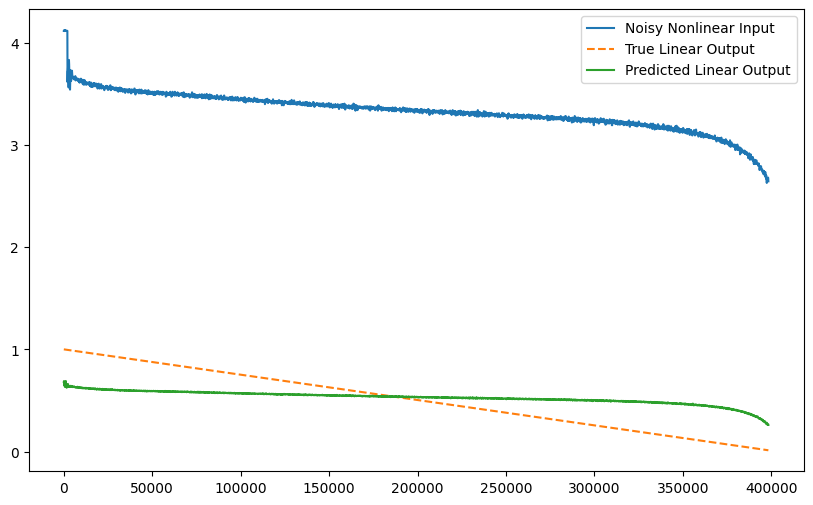

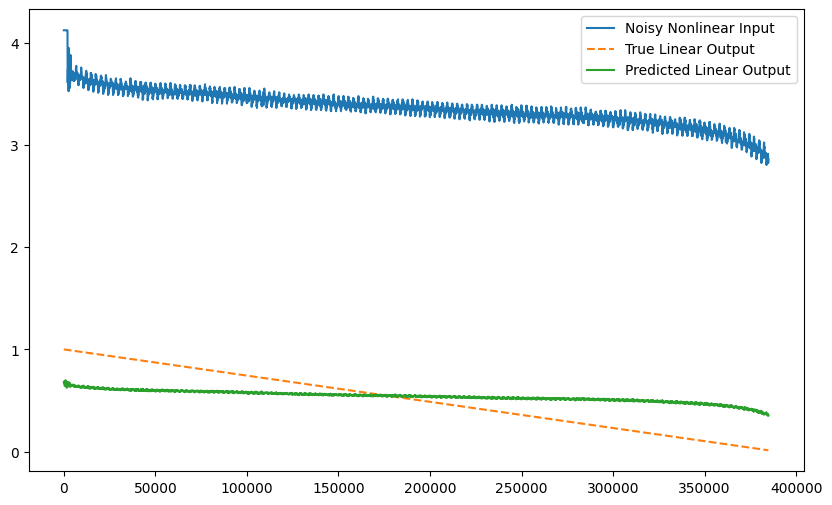

In [8]:
# Test the model
def test(X, data):
    model.eval()
    with torch.no_grad():
        predicted = model(X).numpy()  # Shape: (batch_size, seq_length)
    
    # Plot results
    t = data[2]
    plt.figure(figsize=(10, 6))
    plt.plot(t[:len(predicted)], data[0][:len(predicted)], label='Noisy Nonlinear Input')
    plt.plot(t[:len(predicted)], data[1][:len(predicted)], label='True Linear Output', linestyle='--')
    #plt.plot(t[:len(predicted)], predicted.mean(axis=1), label='Predicted Linear Output')  # Mean across batch
    plt.plot(t[:len(predicted)], predicted[:, 0], label='Predicted Linear Output')  # Mean across batch
    plt.legend()
    plt.show()

test(X_train, train_data)
test(X_test, test_data)